In [3]:
from src.utils import heist
from src.utils import helpers
import torch

import gym
import random
import numpy as np
from src.utils.helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_impala import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random
import src.utils.steering_experiments
import src.utils.activation_steering_visualisations


ordered_layer_names  = {
    1: 'conv1a',
    2: 'pool1',
    3: 'conv2a',
    4: 'conv2b',
    5: 'pool2',
    6: 'conv3a',
    7: 'pool3',
    8: 'conv4a',
    9: 'pool4',
    10: 'fc1',
    11: 'fc2',
    12: 'fc3',
    13: 'value_fc',
    14: 'dropout_conv',
    15: 'dropout_fc'
}


ENTITY_COLORS = {
    "blue": 0,
    "green": 1,
    "red": 2
}

ENTITY_TYPES = {
    "key": 2,
    "lock": 1,
    "gem": 9,
    "player": 0
}



In [4]:
def find_smallest_entry_all_layers(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    activation_width = math.sqrt(flattened_matrices.shape[1])
    ratio = 9/activation_width
    
    # Find the maximum value in the flattened matrix array
    min_value = np.min(flattened_matrices)
   
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    min_index_flat = np.argmin(flattened_matrices)
   
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = min_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = min_index_flat % num_cols  # remainder to find index within the matrix

    x, y = position
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = math.floor(x/ratio) + activation_width* math.floor((9-y)/ratio)
        if within_matrix_index in range(int(calculate_position - ((activation_width/4))), int(calculate_position+((activation_width/4)) +1)):
            if min_value < 0:
                return matrix_index, within_matrix_index, min_value
 
    return -1, -1, -1

def find_largest_entry_all_layers(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    activation_width = math.sqrt(flattened_matrices.shape[1])
    ratio = 9/activation_width

    
    # Find the maximum value in the flattened matrix array
    max_value = np.max(flattened_matrices)
    
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    max_index_flat = np.argmax(flattened_matrices)
    
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = max_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = max_index_flat % num_cols  # remainder to find index within the matrix
    x, y = position
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = math.floor(x/ratio) + activation_width* math.floor((9-y)/ratio)
        if within_matrix_index in range(int(calculate_position - ((activation_width/4))), int(calculate_position+((activation_width/4)) +1)):
            return matrix_index, within_matrix_index, max_value
 
    return -1, -1, -1

def get_flattened_channel_activations(matrices, channel):
    # Ensure channel is valid
    if channel < 0 or channel >= len(matrices):
        raise ValueError("Invalid channel number")

    # Get the matrix for the specified channel
    matrix = matrices[channel]

    # Flatten the matrix and return as a list
    return matrix.flatten().tolist()

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


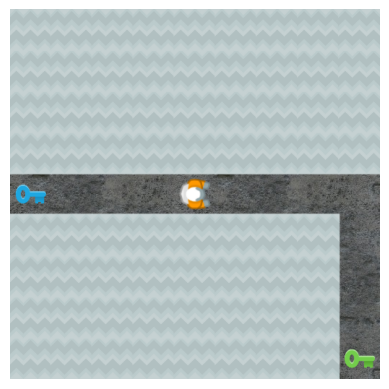

In [5]:
from src.utils.steering_experiments import *
blue_key = ("key", "blue")
green_key = ("key", "green")
venv = create_corridor_with_corner_environment(blue_key, green_key)
obs = venv.reset()
frame = venv.render(mode='rgb_array')
helpers.plot_single_observation(frame)

In [6]:
def calculate_steering_vector(venv, state, entity_type, entity_theme, model, layer_number, ordered_layer_names):
    unchanged_obs = venv.reset()
    # Save the current position of the target entity
    original_position = state.get_entity_position(ENTITY_TYPES["key"], ENTITY_COLORS["green"])
    blue_key_position = state.get_entity_position(ENTITY_TYPES["key"], ENTITY_COLORS["blue"]) 

    # Move the target entity off-screen
    state.remove_entity(entity_type, entity_theme)

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    # Restore the entity to its original position
    state.restore_entity_position(entity_type, entity_theme, original_position)

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])

    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer] - modified_obs_activations[steering_layer]

    return steering_vector, original_position, blue_key_position

def create_activation_heatmap(activations_over_time, channel_shape=None):
    """
    Create a 2D heatmap of channel activations over time.
    
    :param activations_over_time: List of flattened activations, each representing a time step
    :param channel_shape: Original shape of the channel (optional, used for x-axis labeling)
    :return: None (displays the plot)
    """
    # Convert list of activations to a 2D numpy array
    activation_matrix = np.array(activations_over_time)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(activation_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Activation Strength')
    
    # Set labels and title
    ax.set_xlabel('Grid Index',fontsize=14)
    ax.set_ylabel('Time Step',fontsize=14)
    # ax.set_title('Channel Activation Heatmap Over Time')
    
    # If channel_shape is provided, use it to label x-axis
    if channel_shape:
        total_cells = np.prod(channel_shape)
        tick_locations = np.linspace(0, total_cells - 1, 5).astype(int)
        ax.set_xticks(tick_locations)
        ax.set_xticklabels([f'({i // channel_shape[1]}, {i % channel_shape[1]})' for i in tick_locations])
        # plt.title(titles[i], fontsize=14)

    plt.tight_layout()
    plt.show()

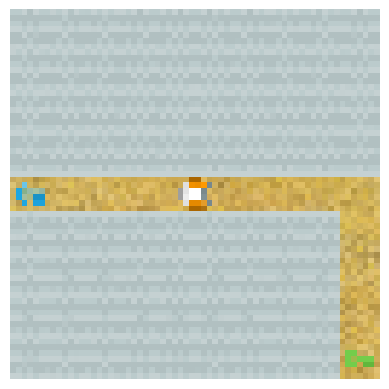

In [28]:

venv = create_corridor_with_corner_environment(blue_key, green_key)
state = heist.state_from_venv(venv,0)
state_bytes = state.state_bytes
helpers.plot_single_observation(venv.reset())
model_path = "../model_interpretable.pt"
model = helpers.load_interpretable_model(model_path=model_path)
# model.eval()

In [33]:
from src.utils.steering_experiments import create_corridor_with_corner_environment


def run_corridor_experiment(venv,model, chosen_position):

    blue_key = ("key", "blue")
    green_key = ("key", "green")
    entity_type, entity_theme = green_key  # Assuming we want to focus on the green key
    state = heist.state_from_venv(venv, 0)
    layer_number = 8




    observation = venv.reset()
    done = False
    total_reward = 0
    frames = []
    observations = []
    count = 0
    steps_until_pickup = 0
    results_big = []
    results_small = []

    initial_state = heist.state_from_venv(venv, 0)
    initial_entity_count = initial_state.count_entities(ENTITY_TYPES[green_key[0]], ENTITY_COLORS[green_key[1]])

    channel_4_activations = []
    # helpers.plot_single_observation(observation)
    while not done:
        # if save_gif:
        #     frames.append(venv.render(mode='rgb_array'))
        state = heist.state_from_venv(venv, 0)

        steering_vector, green_key_position, blue_key_position = calculate_steering_vector(venv, state, entity_type, entity_theme, model, layer_number, ordered_layer_names)
        observation = np.squeeze(observation)
        observation = np.transpose(observation, (1, 2, 0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action(model, converted_obs, is_procgen_env=True)

        observation, reward, done, info = venv.step(action)
        total_reward += reward

        channel_4_activations.append(get_flattened_channel_activations(steering_vector,8))
        
        
        # results.append(find_smallest_entry_all_layers(steering_vector, original_position))
        result_big = find_largest_entry_all_layers(steering_vector, chosen_position)
        if result_big != (-1,-1,-1):
            results_big.append(result_big)
        #     # helpers.plot_single_observation(observation)
        
        result_small = find_smallest_entry_all_layers(steering_vector, chosen_position)
        if result_small != (-1,-1,-1):
            results_small.append(result_small)
        print(steps_until_pickup)
        # helpers.plot_single_observation(observation)
        # create_activation_heatmap(channel_4_activations)

            # print(result_small)
        
        current_entity_count = state.count_entities(ENTITY_TYPES[green_key[0]], ENTITY_COLORS[green_key[1]])
        if current_entity_count != initial_entity_count:
            done = True
        steps_until_pickup += 1
        if steps_until_pickup > 120:
            done = True
    
    return channel_4_activations


steering_vectors_list = []
green_key_positions = []
blue_key_positions = []
decision_square_position = (8.5, 4.5)
green_key_position = (8.5, 0.5)
random_corridor_position = (8.5, 4.5)
chosen_position=decision_square_position

results_big = []
results_small = []
# for _ in range(1):
#     result_big, result_small = run_corridor_experiment(chosen_position)
#     results_big.append(result_big)
#     results_small.append(result_small)

    # steering_vectors_list.append(steering_vector)
    # green_key_positions.append(green_key_position)
    # blue_key_positions.append(blue_key_position)
    # # print(find_largest_entry_all_layers(steering_vector, green_key_position))
    # print(find_smallest_entry_all_layers(steering_vector, green_key_position))

if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
activations_over_time = run_corridor_experiment(venv,model, decision_square_position)
# create_activation_heatmap(activations_over_time)
# print("big results")
# for result in results_big:
#     print(result)

# print("small results")
# for result in results_small:

#     print(result)
# After the loop, you can access the results as lists

# steering_vectors_list contains 20 steering vectors
# green_key_positions contains 20 green key positions
# blue_key_positions contains 20 blue key positions

#grey = positive
# yellow = positive
# mossy grey = less positive
# dark brown = mostly negative
# sandy = almost negative

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [36]:
from src.utils.steering_experiments import create_corridor_with_corner_environment


def run_corridor_experiment(venv,model, chosen_position):

    blue_key = ("key", "blue")
    green_key = ("key", "green")
    entity_type, entity_theme = green_key  # Assuming we want to focus on the green key
    state = heist.state_from_venv(venv, 0)
    layer_number = 8




    observation = venv.reset()
    done = False
    total_reward = 0
    frames = []
    observations = []
    count = 0
    steps_until_pickup = 0
    results_big = []
    results_small = []

    initial_state = heist.state_from_venv(venv, 0)
    initial_entity_count = initial_state.count_entities(ENTITY_TYPES[green_key[0]], ENTITY_COLORS[green_key[1]])

    channel_4_activations = []
    while not done:
        # if save_gif:
        #     frames.append(venv.render(mode='rgb_array'))
        state = heist.state_from_venv(venv, 0)

        steering_vector, green_key_position, blue_key_position = calculate_steering_vector(venv, state, entity_type, entity_theme, model, layer_number, ordered_layer_names)
        observation = np.squeeze(observation)
        observation = np.transpose(observation, (1, 2, 0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action(model, converted_obs, is_procgen_env=True)

        observation, reward, done, info = venv.step(action)
        total_reward += reward

        channel_4_activations.append(get_flattened_channel_activations(steering_vector,4))
        
        
        # results.append(find_smallest_entry_all_layers(steering_vector, original_position))
        result_big = find_largest_entry_all_layers(steering_vector, chosen_position)
        if result_big != (-1,-1,-1):
            results_big.append(result_big)
        #     # helpers.plot_single_observation(observation)
        
        result_small = find_smallest_entry_all_layers(steering_vector, chosen_position)
        if result_small != (-1,-1,-1):
            results_small.append(result_small)
        print(steps_until_pickup)
        # helpers.plot_single_observation(observation)
            # print(result_small)
        
        current_entity_count = state.count_entities(ENTITY_TYPES[green_key[0]], ENTITY_COLORS[green_key[1]])
        if current_entity_count != initial_entity_count:
            done = True
        steps_until_pickup += 1
        if steps_until_pickup > 120:
            done = True
    
    return results_big, results_small


steering_vectors_list = []
green_key_positions = []
blue_key_positions = []
decision_square_position = (8.5, 4.5)
green_key_position = (8.5, 0.5)
random_corridor_position = (6.5, 4.5)
chosen_position=green_key_position

results_big = []
results_small = []
for _ in range(100):
    result_big, result_small = run_corridor_experiment(venv, model,chosen_position)
    results_big.append(result_big)
    results_small.append(result_small)

    steering_vectors_list.append(steering_vector)
    # green_key_positions.append(green_key_position)
    # blue_key_positions.append(blue_key_position)
    # print(find_largest_entry_all_layers(steering_vector, green_key_position))
    # print(find_smallest_entry_all_layers(steering_vector, green_key_position))

# if state_bytes is not None:
#     venv.env.callmethod("set_state", [state_bytes])
# activations_over_time = run_corridor_experiment(venv,model, decision_square_position)
# create_activation_heatmap(activations_over_time)
# # print("big results")
# for result in results_big:
#     print(result)

# print("small results")
# for result in results_small:

#     print(result)
# After the loop, you can access the results as lists
# steering_vectors_list contains 20 steering vectors
# green_key_positions contains 20 green key positions
# blue_key_positions contains 20 blue key positions

#grey = positive
# yellow = positive
# mossy grey = less positive
# dark brown = mostly negative
# sandy = almost negative

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
0
1
2
3
4


(16, 37, -0.19877982)
(22, 41, -0.11691588)
(8, 40, -0.11224292)
(18, 41, -0.19632106)
(29, 39, -0.14894767)
(22, 40, -0.10576618)
(31, 37, -0.06473708)
(27, 38, -0.27497935)
(12, 40, -0.14364423)
(23, 38, -0.14595616)
(2, 39, -0.24626732)
(4, 40, -0.17666695)
(4, 40, -0.24855074)
(16, 38, -0.113458395)
(18, 37, -0.11497742)
(27, 40, -0.71123976)
(8, 40, -0.046901405)
(8, 37, -0.14324147)
(23, 38, -0.29159296)
(22, 41, -0.5924047)
(2, 39, -0.6992506)
(31, 41, -0.29721195)
(31, 41, -0.16315019)
(24, 41, -0.073982894)
(21, 37, -0.08951926)
(23, 38, -0.19162047)
(18, 41, -0.12216616)
(27, 41, -0.10045633)
(3, 41, -0.27518082)
(31, 41, -0.20218748)
(27, 41, -0.15334481)
(27, 37, -0.16218656)
(22, 40, -0.12990502)
(5, 41, -0.07409674)
(4, 37, -0.20187208)
(5, 41, -0.19886535)
(6, 40, -0.101884246)
(3, 37, -0.26306581)
(22, 40, -0.6256127)
(14, 41, -0.21199551)
(4, 37, -0.1067127)
(3, 37, -0.31131446)
(3, 40, -0.32908952)
(30, 40, -0.11154942)
(5, 40, -0.21004)
(16, 39, -0.09156591)
(3, 38, 

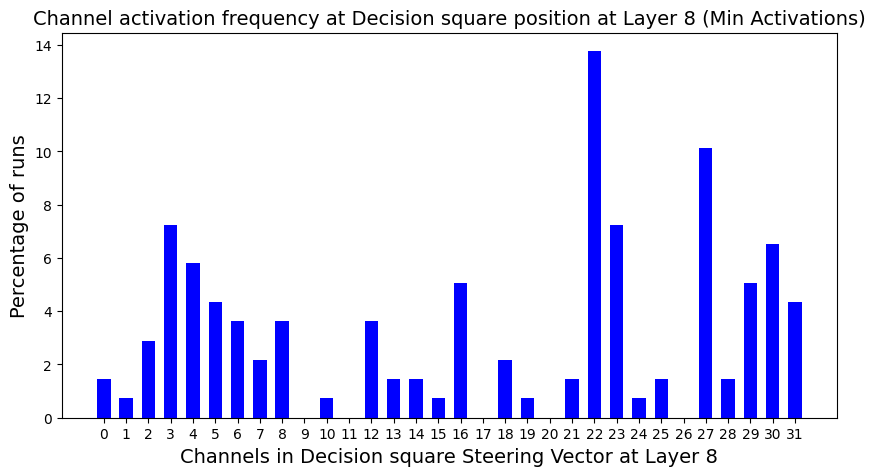

(6, 37, 0.1171056)
(22, 40, 0.13120405)
(22, 41, 0.1099208)
(29, 40, 0.45120966)
(3, 37, 0.37566078)
(29, 38, 0.09204918)
(22, 37, 0.072187304)
(25, 38, 0.18023992)
(3, 41, 0.33775198)
(3, 40, 0.6211418)
(23, 38, 0.18794322)
(13, 37, 0.2340824)
(4, 37, 0.24868369)
(13, 39, 0.32580435)
(23, 38, 0.6292186)
(22, 37, 0.8798152)
(31, 41, 0.27828997)
(31, 41, 0.26280946)
(30, 39, 0.20600554)
(23, 39, 0.19314227)
(13, 38, 0.16608584)
(31, 37, 0.17286626)
(22, 40, 0.12121558)
(27, 41, 0.14928503)
(23, 41, 0.31185007)
(23, 41, 0.76548135)
(10, 41, 0.29883757)
(19, 41, 0.20047385)
(18, 41, 0.24709123)
(5, 41, 0.6065712)
(30, 37, 0.15774345)
(4, 41, 0.30537713)
(31, 41, 0.17394046)
(22, 37, 0.043608665)
(4, 37, 0.19542955)
(3, 39, 0.1546297)
(2, 40, 0.080026805)
(27, 37, 0.25078082)
(7, 37, 0.18184781)
(2, 38, 0.14177859)
(6, 37, 0.11051893)
(22, 37, 0.47959867)
(16, 37, 0.08687353)
(3, 40, 0.19889021)
(30, 40, 0.1117993)
(18, 40, 0.2519074)
(7, 37, 0.102051556)
(2, 39, 0.5263559)
(17, 40, 0.4298

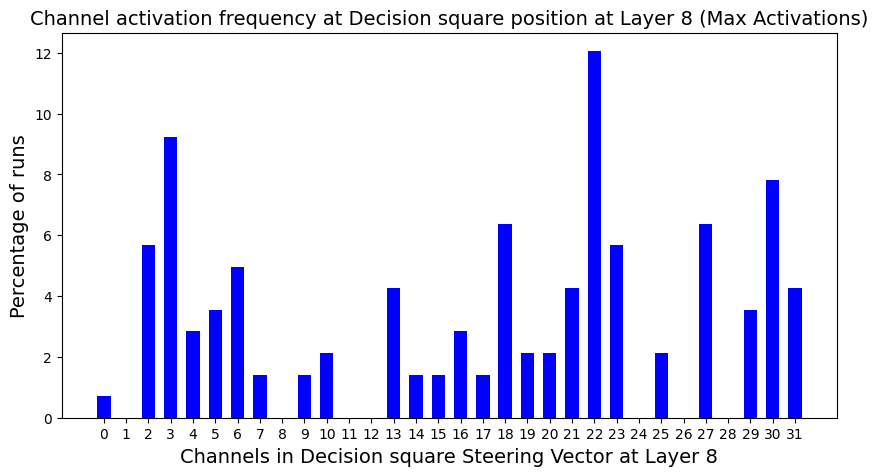

In [222]:
def print_histogram(title, data, layer_number, objective):
    # Data in the form of a dictionary
    # Keys and values extracted from the dictionary
    channels = list(data.keys())
    frequencies = list(data.values())
    
    # Calculate percentages
    total = sum(frequencies)
    percentages = [freq / total * 100 for freq in frequencies]

    # Plotting the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(channels, percentages, width=0.6, color='blue')

    # Adding labels and title
    plt.xlabel(f'Channels in {objective} Steering Vector at Layer {layer_number}', fontsize=14)
    plt.ylabel('Percentage of runs', fontsize=14)
    plt.title(title, fontsize=14)

    # Setting x-ticks to show every value from 0 to 31
    plt.xticks(range(0, 32))

    # Adjust tick label font size
    plt.tick_params(axis='both', which='major')

    # Show the plot
    plt.show()

import matplotlib.pyplot as plt

def process_results_and_plot_histogram(results, layer_number, objective, max):
    matrix_indices = {}
    for collection in results:
        for result in collection:
            print(result)
            channel, _, _ = result
            if channel not in matrix_indices:
                matrix_indices[channel] = 1
            else:
                matrix_indices[channel] += 1
    
    activation_type = "Max" if max else "Min"
    title = f"Channel activation frequency at {objective} position at Layer {layer_number} ({activation_type} Activations)"
    print_histogram(title, matrix_indices, layer_number, objective)

# Example usage:
process_results_and_plot_histogram(results_small, 8, "Decision square", max=False)
process_results_and_plot_histogram(results_big, 8, "Decision square", max=True)

# You can also use it for results_big:
# process_results_and_plot_histogram(results_big, 8, "green_key")

In [156]:
results_small

[[(28, 61, -0.18141375), (3, 63, -0.7128022)],
 [(22, 61, -0.02570653), (29, 63, -0.31037837), (4, 63, -0.44192004)],
 [(6, 62, -0.111121684),
  (29, 63, -0.10517043),
  (8, 62, -0.15691358),
  (5, 62, -0.046250537),
  (29, 63, -0.23304039)],
 [(25, 63, -0.11458242), (29, 63, -0.08828437)],
 [(25, 63, -0.16707921),
  (29, 63, -0.26637477),
  (8, 62, -0.19514501),
  (27, 63, -0.17988956)],
 [(7, 62, -0.20001769),
  (27, 63, -0.17083478),
  (22, 61, -0.3439629),
  (4, 63, -0.50891584),
  (29, 63, -0.4028064)],
 [(16, 63, -0.040612936)],
 [(27, 63, -0.19638407),
  (9, 61, -0.2649177),
  (22, 61, -0.29714346),
  (26, 63, -0.087923355),
  (3, 63, -0.80491626)],
 [(5, 62, -0.053291276), (6, 63, -0.42387915)],
 [(29, 63, -0.113844335)]]

(-1, -1, -1)

In [21]:
print(math.floor(blue_key_position[0]/1.125) + 8* math.floor((9-blue_key_position[1])/1.125))
print(math.floor(green_key_position[0]/1.125) + 8* math.floor((9-green_key_position[1])/1.125))


NameError: name 'blue_key_position' is not defined

In [ ]:
model_path = "../model_interpretable.pt"
blue_key = ("key", "blue")
green_key = ("key", "green")
venv = create_corridor_environment(blue_key, green_key)
model = helpers.load_interpretable_model(model_path=model_path)

obs = venv.reset()
done = False
total_reward = 0
max_steps = 200

for episode in range(20):
    venv = create_corridor_environment(blue_key, green_key)
    total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'gifs/episode__corridor{episode}.gif', save_gif=save_gif_option, is_procgen_env=True)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

# print(f"Episode finished after {step+1} steps. Total reward: {total_reward}")

Episode 1 finished with total reward: [0.]
Episode 2 finished with total reward: [0.]
Episode 3 finished with total reward: [0.]
Episode 4 finished with total reward: [0.]
Episode 5 finished with total reward: [0.]
Episode 6 finished with total reward: [0.]


KeyboardInterrupt: 

In [ ]:
model_path = "../model_interpretable.pt"
blue_key = ("key", "blue")
green_key = ("key", "green")
save_gif_option = True  


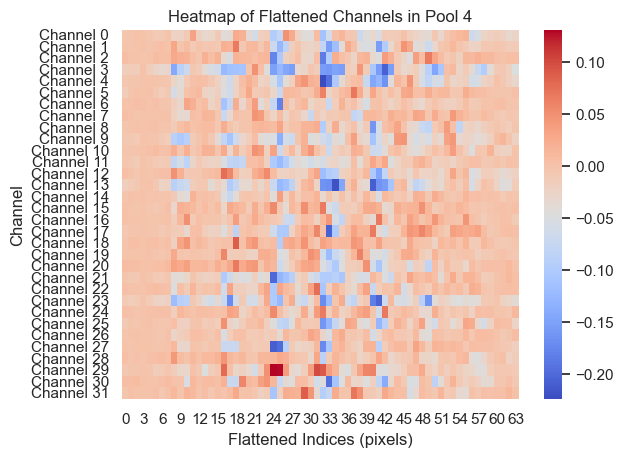

In [ ]:

def visualize_heatmap(matrices):
    # Flatten each matrix in the list
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])

    # Create a heatmap
    sns.heatmap(flattened_matrices, annot=False, cmap='coolwarm', cbar=True, 
                yticklabels=[f'Channel {i}' for i in range(len(matrices))])
    plt.title("Heatmap of Flattened Channels in Pool 4")
    plt.xlabel("Flattened Indices (pixels)")
    plt.ylabel("Channel")
    plt.show()

visualize_heatmap(steering_vectors)

In [ ]:

from src.utils.steering_experiments import create_corridor_environment



def compare_blue_green_key_collection(model_path, num_episodes=100):
    blue_key_collected = 0
    green_key_collected = 0
    neither_collected = 0

    for episode in range(num_episodes):
        # Create the corridor environment with blue and green keys
        venv = create_corridor_environment(
            entity_one=("key", "blue"),
            entity_two=("key", "green"),
            corridor_length=9
        )

        model = helpers.load_interpretable_model(model_path=model_path)
        
        obs = venv.reset()
        done = False
        steps = 0
        max_steps = 100  # Prevent infinite loops
        
        while not done and steps < max_steps:
            action = model.act(obs)
            obs, reward, done, info = venv.step(action)
            steps += 1
            
            # Check if a key was collected
            if reward > 0:
                # Determine which key was collected based on the remaining entities
                state = heist.state_from_venv(venv)
                remaining_keys = [ent for ent in state.state_vals["ents"] if ent["image_type"].val == ENTITY_TYPES["key"]]
                
                if len(remaining_keys) == 1:
                    if remaining_keys[0]["image_theme"].val == ENTITY_COLORS["blue"]:
                        green_key_collected += 1
                    else:
                        blue_key_collected += 1
                    break
        
        if steps == max_steps:
            neither_collected += 1
        
        venv.close()

    total_collected = blue_key_collected + green_key_collected
    results = {
        "blue_key_collected": blue_key_collected,
        "green_key_collected": green_key_collected,
        "neither_collected": neither_collected,
        "blue_key_percentage": blue_key_collected / total_collected * 100 if total_collected > 0 else 0,
        "green_key_percentage": green_key_collected / total_collected * 100 if total_collected > 0 else 0
    }
    
    return results


model_path = "../model_interpretable.pt"
results = compare_blue_green_key_collection(model_path, num_episodes=100)
print(results)


AttributeError: 'CustomCNN' object has no attribute 'act'

In [ ]:
from src.utils.steering_experiments import run_entity_steering_experiment, run_entity_steering_experiment_by_channel, run_patching_experiment
model_path = "../model_interpretable.pt"
total_episodes = 5
layer_success_counts = {}
patching_objectives = {}

entity = ["key"]
entity_colors = ["green"]

import itertools
import random

all_positions = list(itertools.product(range(8), repeat=2))
patch_positions = random.sample(all_positions, 20)

patch_positions = [(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]

patch_value = 3
target_channel = 4
layer_number = 8

save_gif = False
for channel in [target_channel]:  # Run channels 0 to 31
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = None
            total_reward = 0
            total_steps_until_pickup = 0
            total_count_pickups = 0
            
            for episode, patch_position in enumerate(patch_positions):
                reward, steps, pickups = run_patching_experiment(model_path, layer_number, episode, channel,patch_position, patch_value, entity_name, entity_color, save_gif=save_gif)
                total_reward += reward
                total_steps_until_pickup += steps
                total_count_pickups += pickups
            
            if entity_name == "gem":
                entity_color = ""
            
            key = f"{entity_name}{entity_color}_channel{channel}"
            patching_objectives[key] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }


True
Key picked up after 11 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 20 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 20 steps
Saved gif!
Key picked up during the episode
True
Key picked up after 30 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 45 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 16 steps
Saved gif!
Key picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Saved gif!
Key was not picked up during the episode
True
Key picked up after 29 steps
Saved gif!
Key picked up during the episode


In [2]:
from src.utils.steering_experiments import run_entity_steering_experiment, run_entity_steering_experiment_by_channel
from tqdm import tqdm

model_path = "../model_interpretable.pt"
total_episodes = 10
layer_number = 8
layer_success_counts = {}
objectives = {}

modification_values = range(-5, 0)
entity = ["key"]
entity_colors = ["green"]
save_gif = False

from tqdm.auto import tqdm

objectives = {}
for channel in tqdm(range(31), desc="Channels"):
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = None
            
            for modification_value in modification_values:
                total_reward = 0
                total_steps_until_pickup = 0
                total_count_pickups = 0
                
                for episode in range(total_episodes):
                    reward, steps, pickups = run_entity_steering_experiment_by_channel(
                        model_path, layer_number, modification_value, episode, 
                        channel, entity_name, entity_color, save_gif=save_gif
                    )
                    total_reward += reward
                    total_steps_until_pickup += steps
                    total_count_pickups += pickups
                
                if entity_name == "gem":
                    entity_color = ""
                
                key = f"{entity_name}{entity_color}_mod{modification_value}_channel{channel}"
                objectives[key] = {
                    'avg_total_reward': total_reward / total_episodes,
                    'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                    'total_count_pickups': total_count_pickups 
                }

Channels:   0%|          | 0/31 [00:00<?, ?it/s]

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


In [156]:
objectives
# Pickle the objectives_channels dictionary
import pickle


    # Pickle the objectives_channels dictionary
with open('objectives_channels.pkl', 'wb') as f:
    pickle.dump(objectives, f)
    


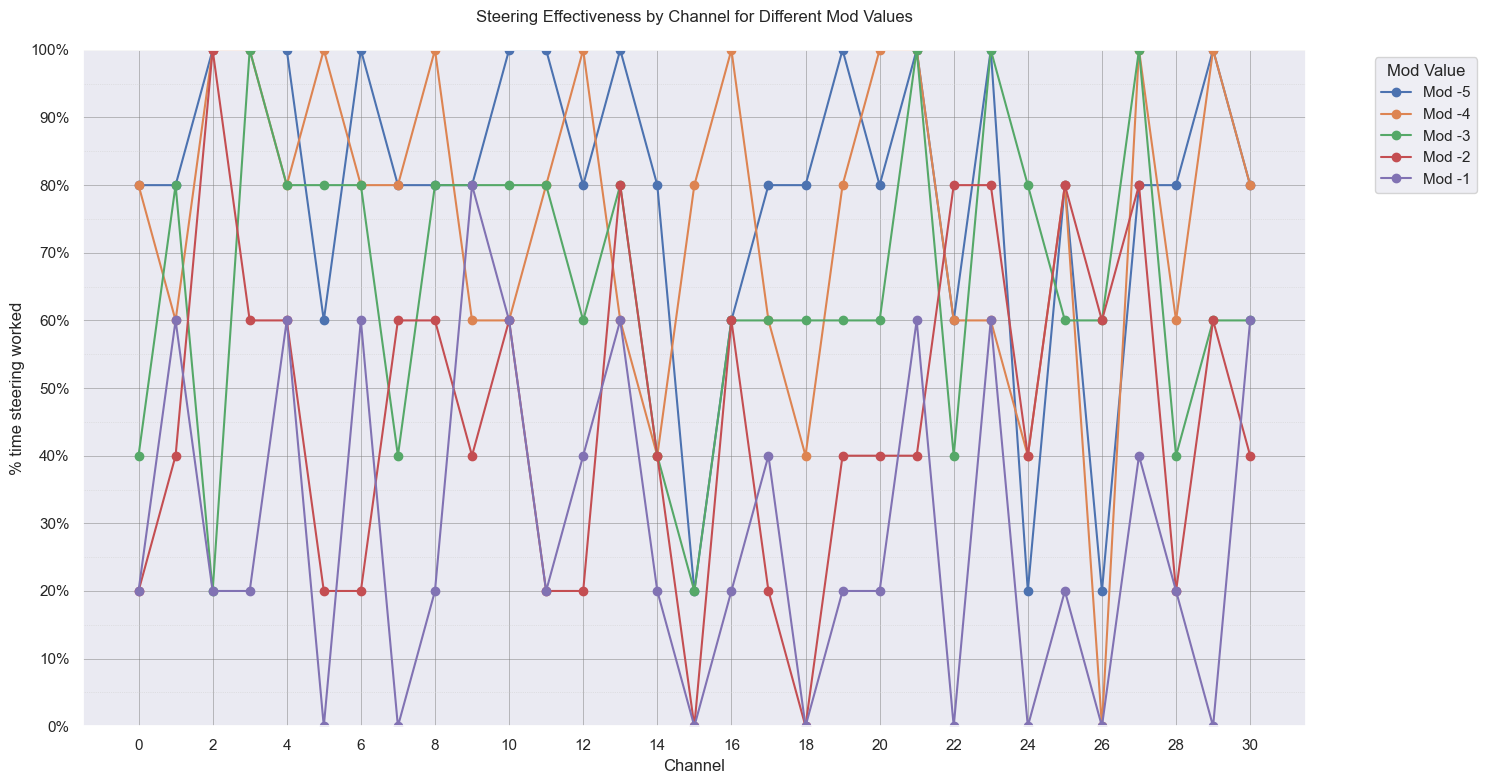

In [ ]:
import activation_steering_visualisations
activation_steering_visualisations.plot_pickup_line_graphs(objectives)

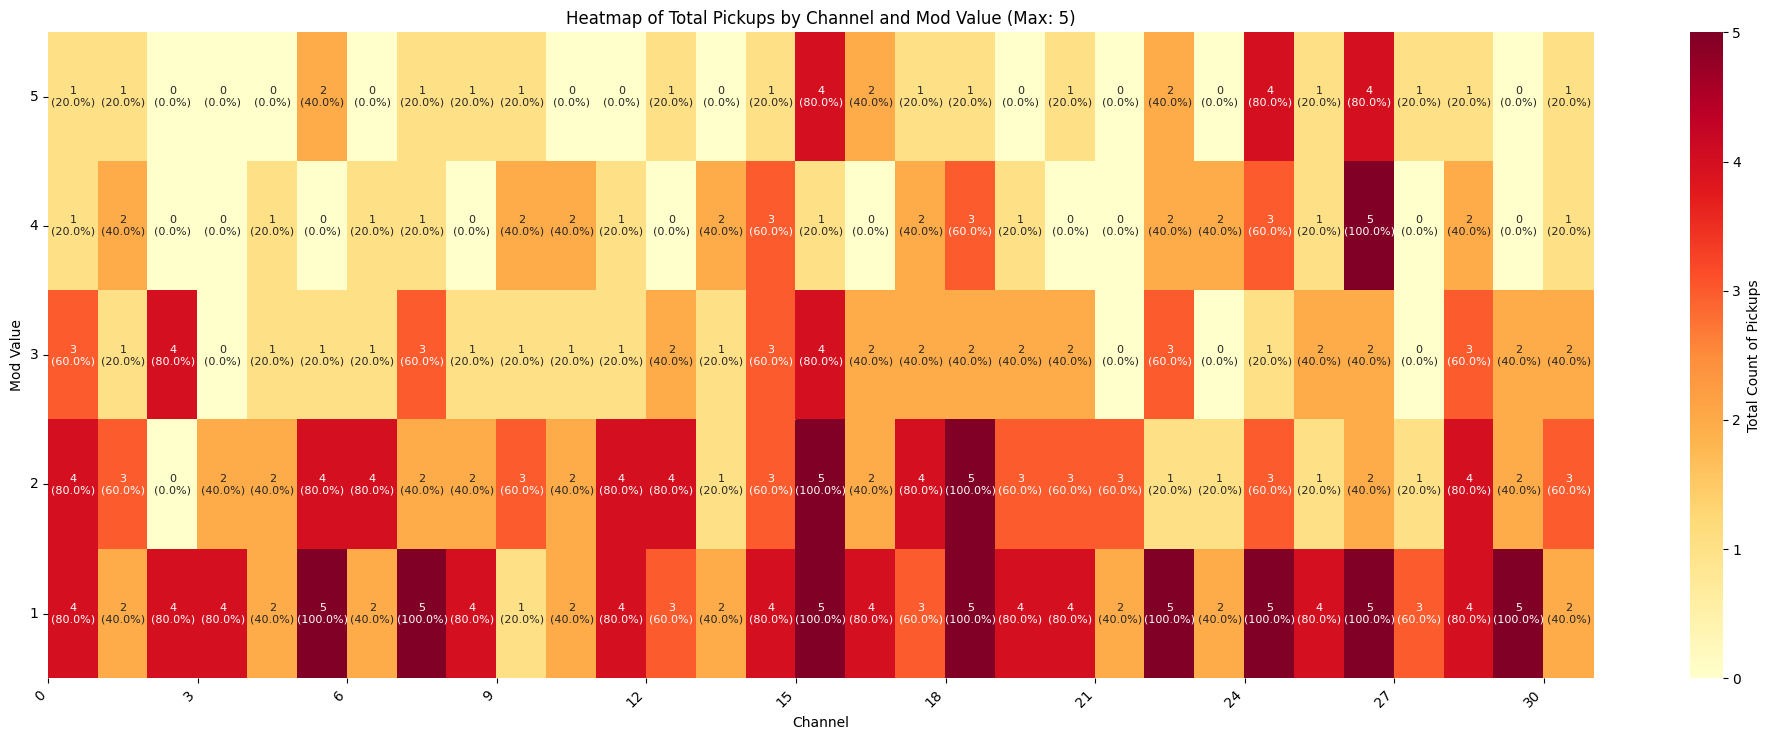

In [ ]:
activation_steering_visualisations.plot_pickup_heatmap(objectives)

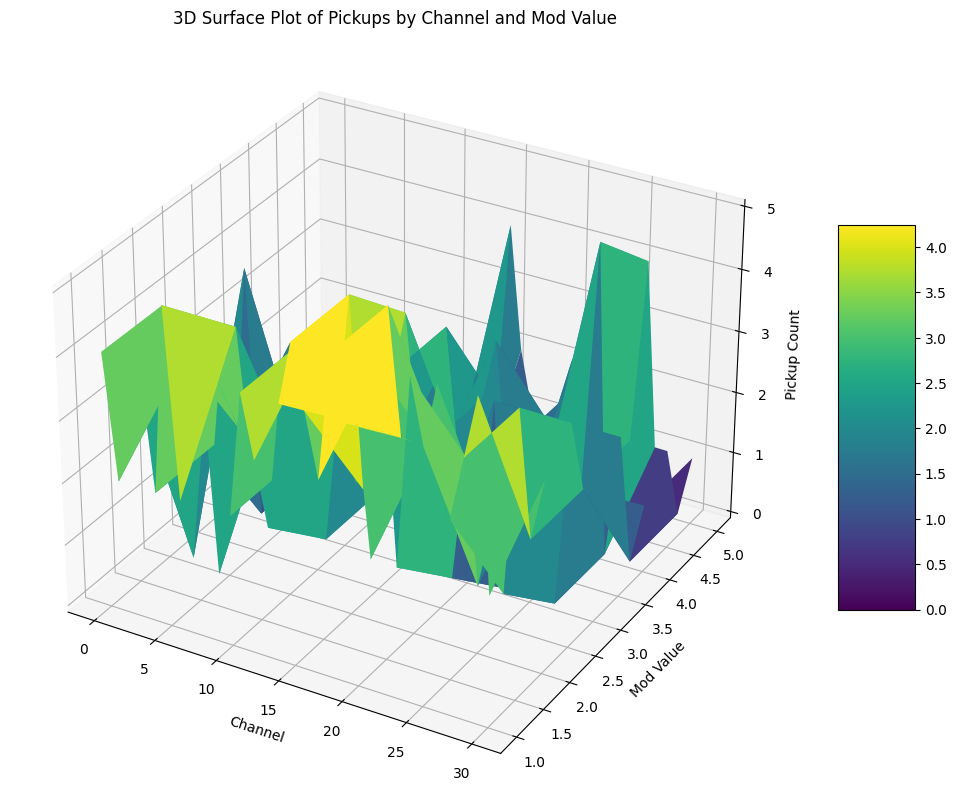

In [ ]:
activation_steering_visualisations.plot_pickup_3d_surface(objectives)

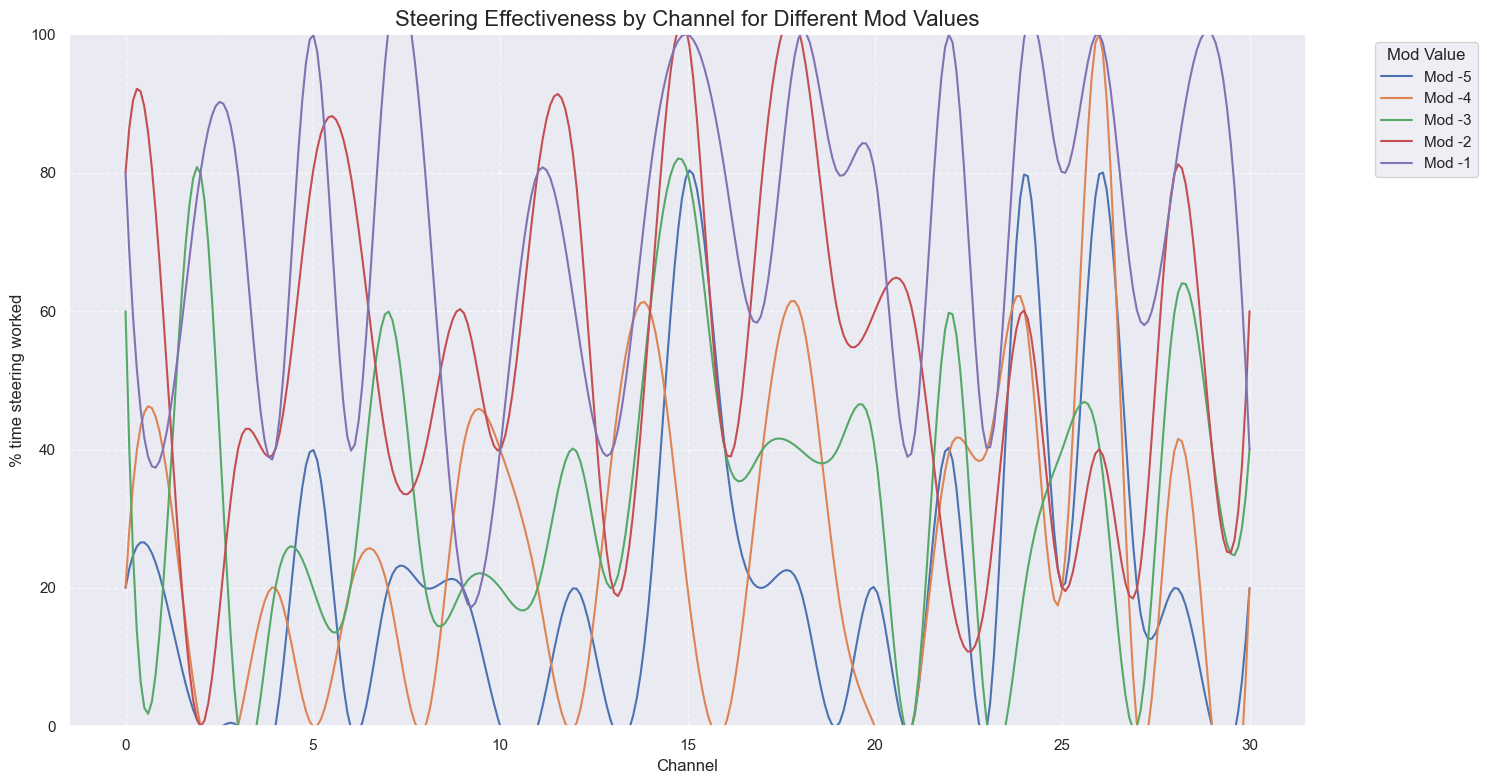

In [ ]:
activation_steering_visualisations.plot_pickup_line_graphs_smooth(objectives)

In [ ]:
import pickle

# Pickle the objectives dictionary
with open('objectives_2.pkl', 'wb') as f:
    pickle.dump(objectives, f)

print("Objectives dictionary has been pickled and saved as 'objectives.pkl'")


Objectives dictionary has been pickled and saved as 'objectives.pkl'


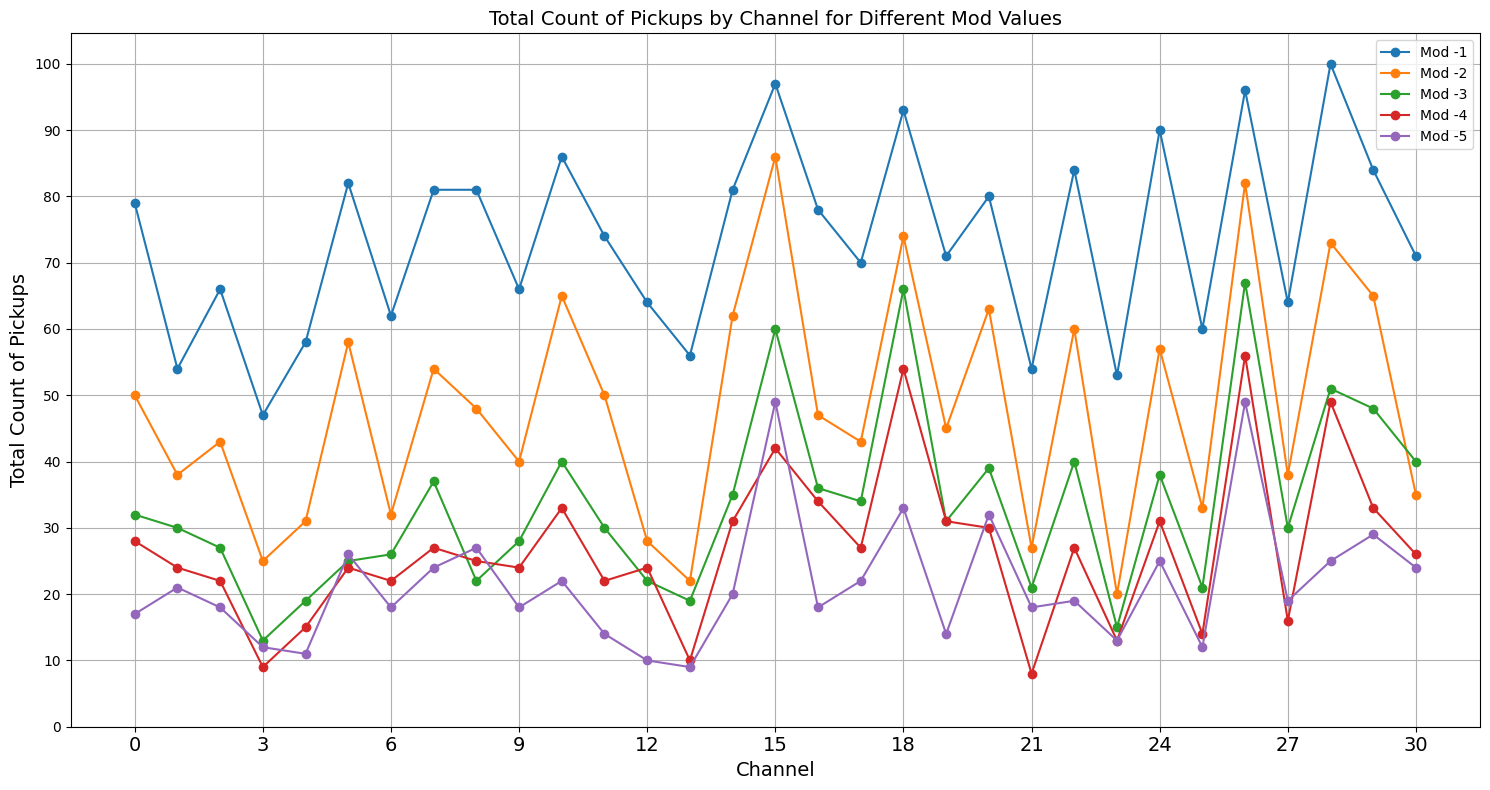

In [210]:
from activation_steering_visualisations import *

plot_total_pickups_by_channel(objectives)

In [ ]:
from src.utils.steering_experiments import run_entity_steering_experiment
import matplotlib.pyplot as plt

model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
episode = 200
objectives = {}

# entity = ["key", "lock", "gem"]
# entity_colors = ["blue", "red", "green"]
entity = ["key"]
entity_colors = ["green"]
# Define the range of layers to iterate through

layers_to_test = range(1, 14)
for layer_number in layers_to_test:

    count_gem = 0
    objectives[layer_number] = {}
    
    for entity_name in entity:
        if entity_name == "gem":
            if count_gem > 1:
                continue
            count_gem  +=1
            entity_color = None
            total_reward = 0
            total_steps_until_pickup = 0
            total_count_pickups = 0
            
            for _ in range(total_episodes):
                reward, steps, pickups = run_entity_steering_experiment(model_path, layer_number, modification_value, episode, entity_name, entity_color)
                total_reward += reward
                total_steps_until_pickup += steps
                total_count_pickups += pickups
            
            entity_color = ""
            objectives[layer_number][ entity_color + entity_name] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }
        else:
            for entity_color in entity_colors:
                total_reward = 0
                total_steps_until_pickup = 0
                total_count_pickups = 0
                
                for _ in range(total_episodes):
                    reward, steps, pickups = run_entity_steering_experiment(model_path, layer_number, modification_value, episode, entity_name, entity_color)
                    total_reward += reward
                    total_steps_until_pickup += steps
                    total_count_pickups += pickups
                
                objectives[layer_number][entity_name + entity_color] = {
                    'avg_total_reward': total_reward / total_episodes,
                    'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                    'total_count_pickups': total_count_pickups 
                }

            
            objectives[layer_number][entity_name + entity_color] = {
                'avg_total_reward': total_reward / total_episodes,
                'avg_steps_until_pickup': total_steps_until_pickup / total_episodes,
                'total_count_pickups': total_count_pickups 
            }


True
Key was not picked up during the episode
True
Key was not picked up during the episode
True
Key was not picked up during the episode
True


KeyboardInterrupt: 

In [ ]:
import pickle

# Save the objectives object to a pickle file
with open('objectives.pkl', 'wb') as f:
    pickle.dump(objectives, f)


In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
layers_to_test = range(1, 14)

# Assuming the experiment has been run and 'objectives' dictionary is populated

metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
entity_combinations = [f"{e}{c}" for e in ["key", "lock"] for c in ["blue", "red", "green"]] + ["gem"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    data = []
    for layer in layers_to_test:
        row = []
        for entity in entity_combinations:
            if entity == "gem":
                value = objectives[layer]["gem"][metric]
            else:
                value = objectives[layer][entity][metric]
            
            # Convert to float if it's a numpy array or other non-float type
            if isinstance(value, np.ndarray):
                value = float(value.item())
            elif not isinstance(value, (int, float)):
                value = float(value)
            
            row.append(value)
        data.append(row)
    
    df = pd.DataFrame(data, columns=entity_combinations, index=list(layers_to_test))
    
    # Rename entities to capture colour and lock or key
    new_entity_names = ['Blue Key', 'Red Key', 'Green Key', 'Blue Lock', 'Red Lock', 'Green Lock', 'Gem']
    df.columns = new_entity_names

    sns.heatmap(df, cmap="YlOrRd", annot=True, fmt=".2f", cbar_kws={'label': metric})
    plt.title(f"Entity Steering Results Across Layers: {metric.replace('_', ' ').title()}")
    plt.xlabel('Entity')
    plt.ylabel('Layer')
    
    plt.tight_layout()
    plt.show()

KeyError: 1

<Figure size 1000x600 with 0 Axes>

In [159]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']
all_entities = ['keyblue', 'keyred', 'keygreen', 'lockblue', 'lockred', 'lockgreen', 'gem']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 8))
    
    for entity in all_entities:
        values = [objectives[layer][entity][metric] for layer in layers_to_test]
        
        # Convert numpy array to float if necessary
        values = [float(v.item()) if isinstance(v, np.ndarray) else float(v) for v in values]
        
        # Create a more readable label
        if entity == 'gem':
            label = 'Gem'
        else:
            entity_type = 'Key' if entity.startswith('key') else 'Lock'
            color = entity[3:] if entity.startswith('key') else entity[4:]
            label = f'{color.capitalize()} {entity_type}'
        
        plt.plot(list(layers_to_test), values, label=label, marker='o')
    
    plt.title(titles[i])
    plt.xlabel('Layer Number')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: If you want to save the plots
    # plt.savefig(f'{metric}_plot.png')
    # plt.close()

KeyError: 1

<Figure size 1200x800 with 0 Axes>

In [ ]:
objectives

{'keygreen_channel0': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 65.8,
  'total_count_pickups': 12},
 'keygreen_channel1': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 48.6,
  'total_count_pickups': 12},
 'keygreen_channel2': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 50.0,
  'total_count_pickups': 12},
 'keygreen_channel3': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 85.2,
  'total_count_pickups': 11},
 'keygreen_channel4': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 73.6,
  'total_count_pickups': 12},
 'keygreen_channel5': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 54.2,
  'total_count_pickups': 12},
 'keygreen_channel6': {'avg_total_reward': array([0.], dtype=float32),
  'avg_steps_until_pickup': 55.4,
  'total_count_pickups': 12},
 'keygreen_channel7': {'avg_total_reward': array([0.], 

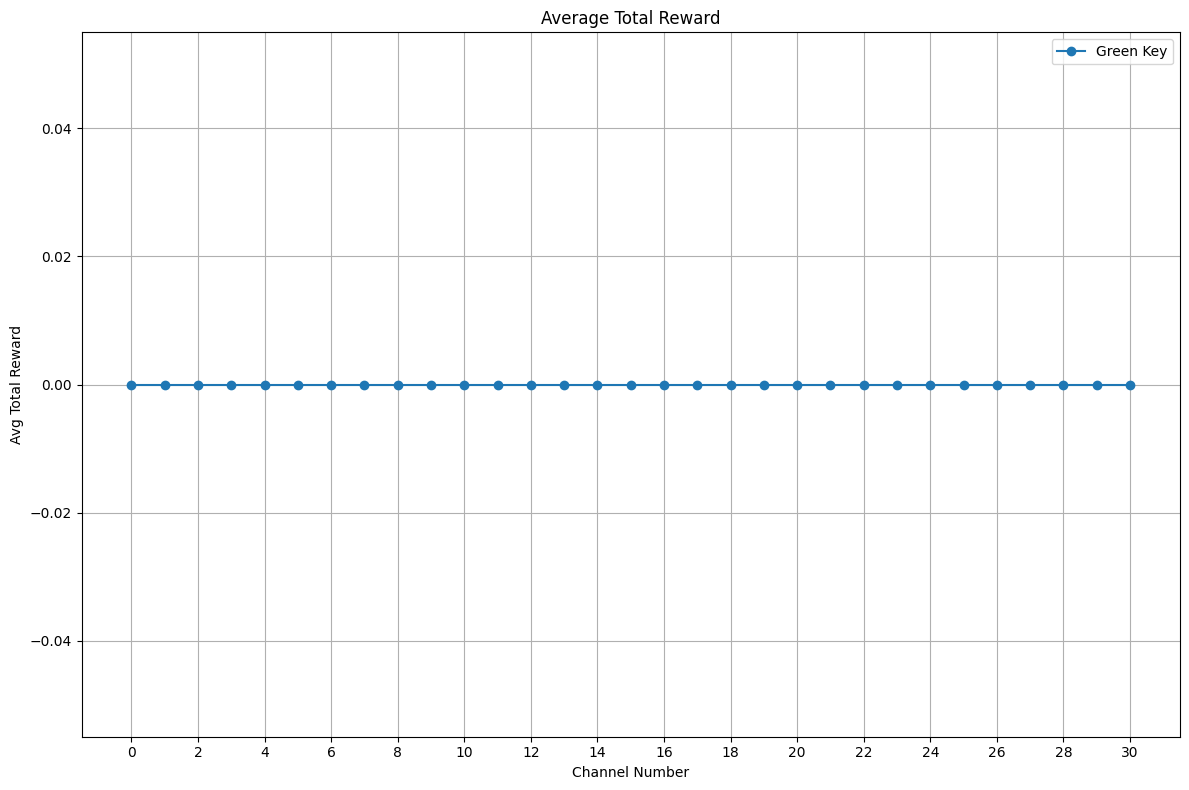

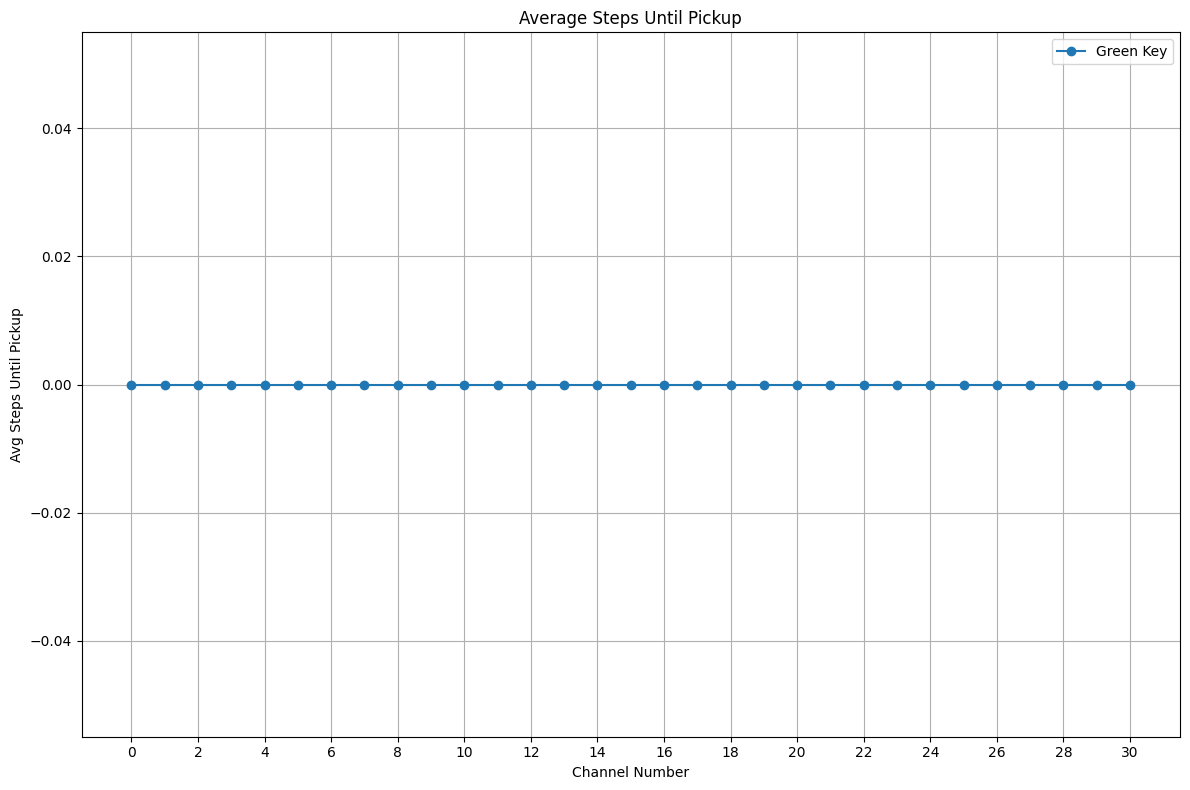

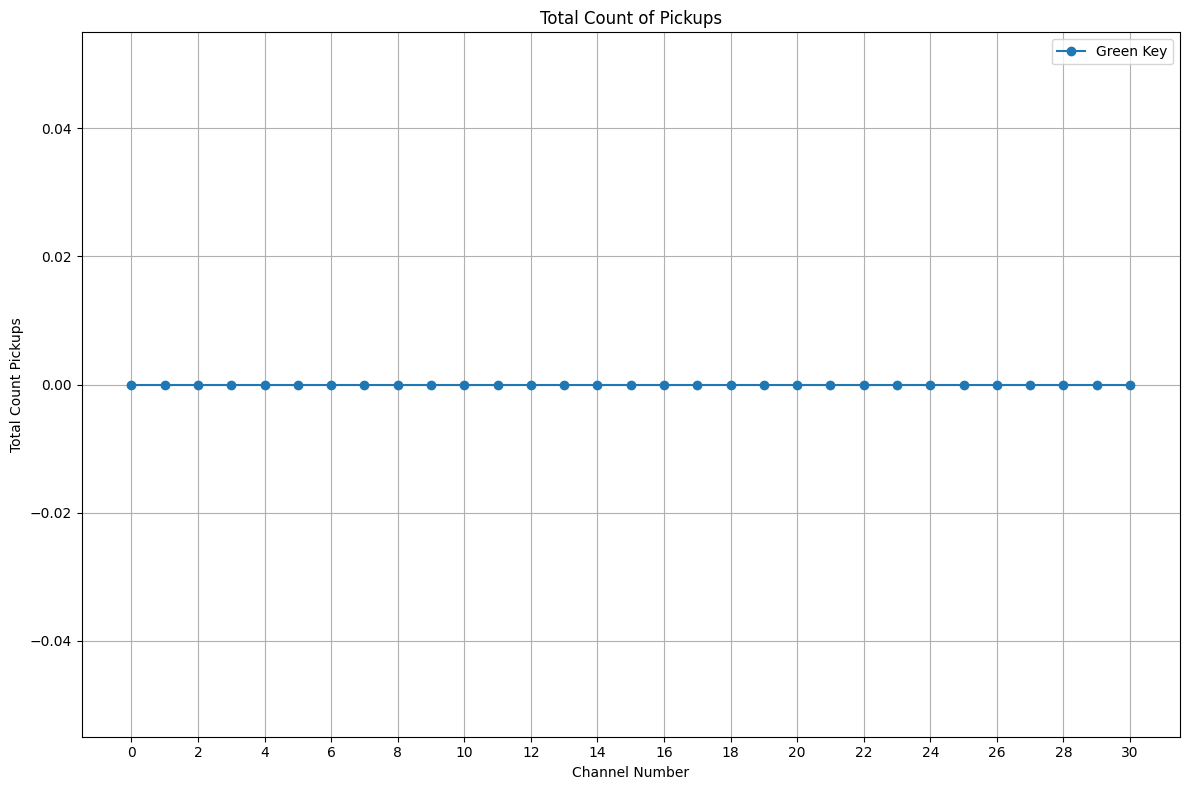

In [160]:
import matplotlib.pyplot as plt
import numpy as np

def plot_channel_metrics(objectives, channels_to_test=range(31)):
    metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
    titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']
    all_entities = ['keygreen']  # Only 'keygreen' is present in the objectives

    for i, metric in enumerate(metrics):
        plt.figure(figsize=(12, 8))
        
        for entity in all_entities:
            values = []
            for channel in channels_to_test:
                channel_key = f'keygreen_channel{channel}'
                if channel_key in objectives:
                    value = objectives[channel_key][metric]
                    values.append(float(value.item()) if isinstance(value, np.ndarray) else float(value))
                else:
                    values.append(0)  # or np.nan if you prefer to show gaps
            
            # Create a more readable label
            label = f'Green Key'
            
            plt.plot(channels_to_test, values, label=label, marker='o')

        plt.title(titles[i])
        plt.xlabel('Channel Number')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.grid(True)
        plt.xticks(range(0, 32, 2))  # Show channel numbers at intervals of 2
        plt.tight_layout()
        plt.show()

# To use the function:
plot_channel_metrics(objectives)

In [ ]:
# Run steering experiment with just a green key and save the gif
from src.utils import helpers
from src.utils import heist
from src.utils.steering_experiments import run_entity_steering_experiment

# Set up experiment parameters
layer_number = 7  # You can adjust this based on previous results
modification_value = -2 # You can adjust this value
episode = 0  # This is just for naming the gif
entity_name = "key"
entity_color = "green"
num_levels = 1
start_level = random.randint(1, 100000)  # Random start level
episode_timeout = 300  # Adjust as needed
save_gif = True

# Run the experiment
total_reward, steps_until_pickup, count_pickups = run_entity_steering_experiment(
    model_path=model_path,
    layer_number=layer_number,
    modification_value=modification_value,
    episode=episode,
    entity_name=entity_name,
    entity_color=entity_color,
    num_levels=num_levels,
    start_level=start_level,
    episode_timeout=episode_timeout,
    save_gif=save_gif
)

print(f"Total reward: {total_reward}")
print(f"Steps until pickup: {steps_until_pickup}")
print(f"Count of pickups: {count_pickups}")

# Display the saved gif
from IPython.display import Image, display
display(Image(filename=f'episode_steering_{episode}.gif'))


True


KeyboardInterrupt: 

KeyError: 1

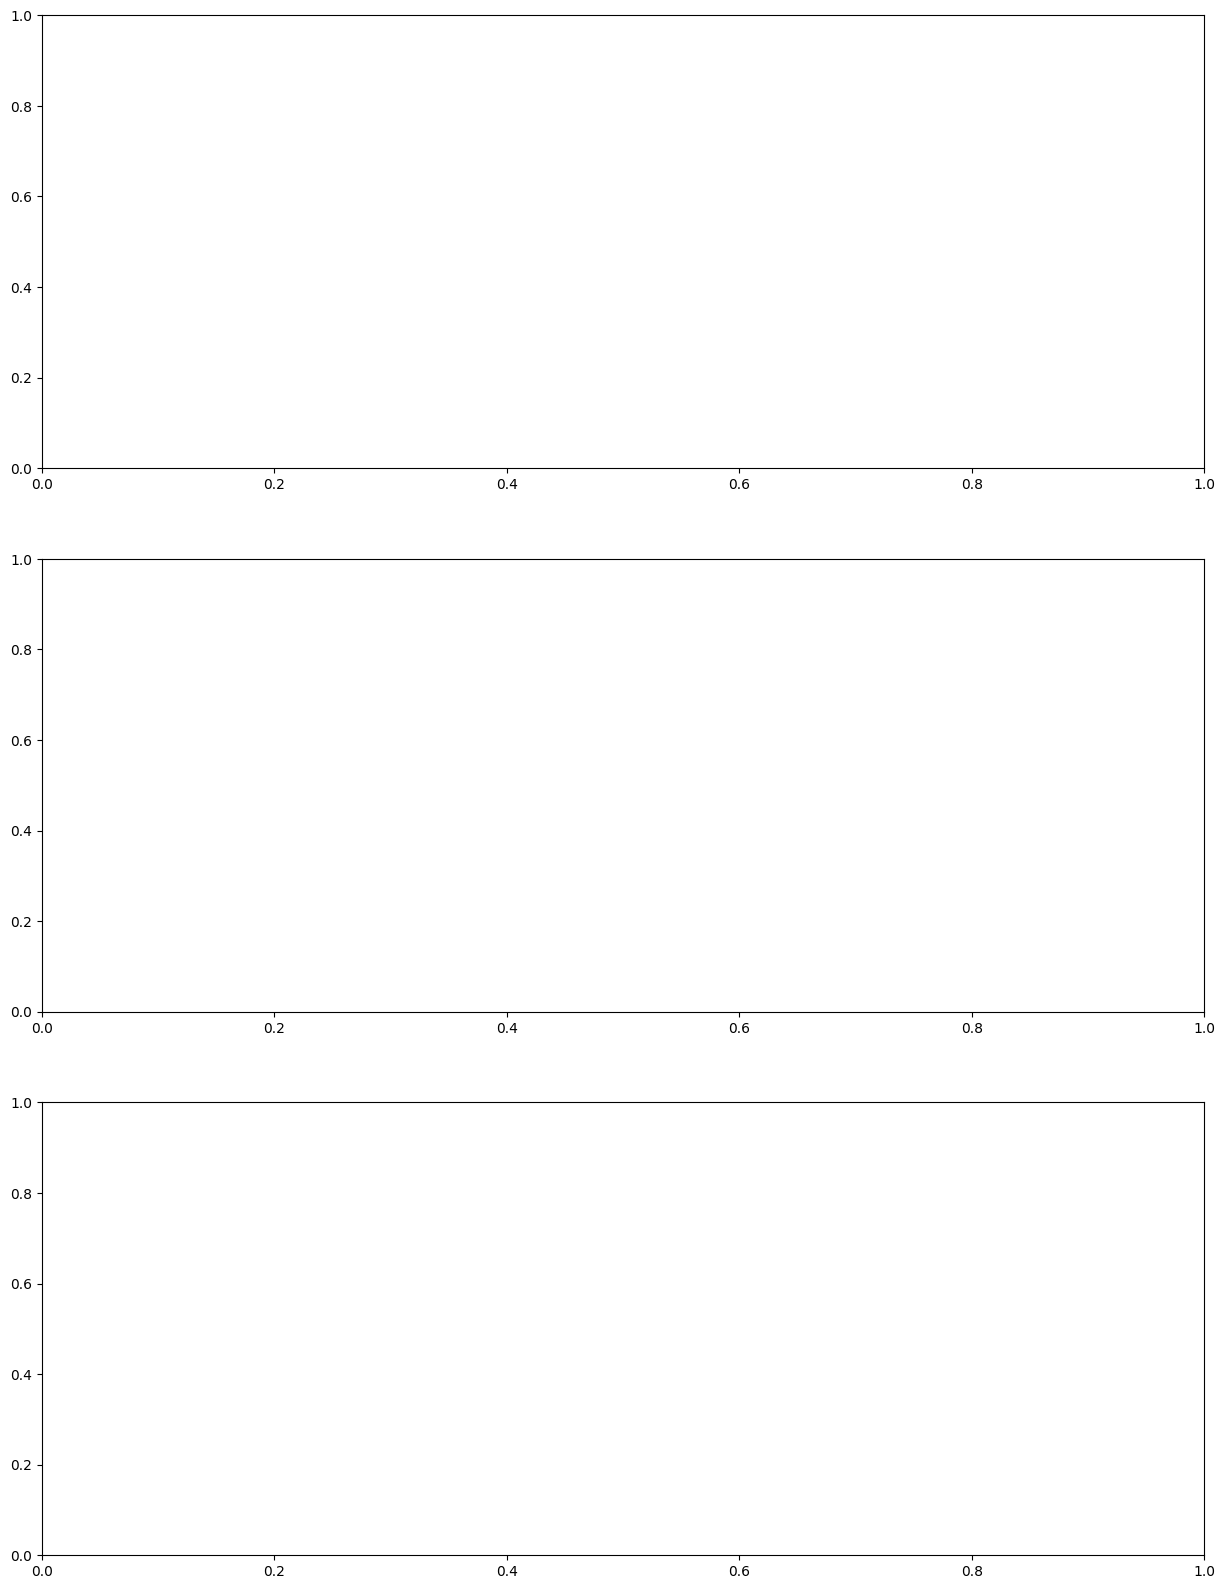

In [ ]:
# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
metrics = ['avg_total_reward', 'avg_steps_until_pickup', 'total_count_pickups']
titles = ['Average Total Reward', 'Average Steps Until Pickup', 'Total Count of Pickups']

for i, metric in enumerate(metrics):
    for entity_name in entity:
        for entity_color in entity_colors:
            if entity_name == "gem":
                entity_color = ""
            label = f"{entity_name}{entity_color}"
            values = [objectives[layer][label][metric] for layer in ordered_layer_names.keys()]
            axs[i].plot(list(ordered_layer_names.keys()), values, label=label)
    
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Layer Number')
    axs[i].set_ylabel(metric.replace('_', ' ').title())
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_interpretable_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    # helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering


model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
layers_to_test = range(1, 14)  # Layers 1 to 15
layer_success_counts = {}

for layer_number in layers_to_test:
    count_rewards_10 = 0
    for episode in range(total_episodes):
        filepath = f'episode_steering_layer{layer_number}_episode{episode}.gif'
        total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, episode, save_gif=False)
        if total_reward_steering == 10:
            count_rewards_10 += 1

    
    layer_success_counts[layer_number] = count_rewards_10
    print(f"Layer {layer_number}: Count rewards 10 out of total episodes: {count_rewards_10}/{total_episodes}")

# # Print summary of results
# for layer, count in layer_success_counts.items():
#     print(f"Layer {layer}: {count}/{total_episodes} successes")

# # Find the best performing layer(s)
# max_success = min(layer_success_counts.values())
# best_layers = [layer for layer, count in layer_success_counts.items() if count == max_success]
# print(f"\nBest performing layer(s): {best_layers} with {max_success}/{total_episodes} successes")

    

In [ ]:
venv = heist.create_venv(num=1, num_levels=1, start_level=2)
state = heist.state_from_venv(venv, 0)

unchanged_obs = venv.reset()

In [ ]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(observations[-1])
    
    
    if total_reward == 0: return True

    

    else: return False

In [ ]:
model_path = "../model_interpretable.pt"
modification_value = -2
total_episodes = 20
layers_to_test = range(1, 14)  # Layers 1 to 15
layer_success_counts = {}

for layer_number in layers_to_test:
    count_rewards_10 = 0
    for episode in range(total_episodes):
        filepath = f'episode_steering_layer{layer_number}_episode{episode}.gif'
        total_reward_steering = run_episode_with_steering_and_check_target_acquisition(model_path, layer_number, modification_value, save_gif=False)
        if total_reward_steering == 10:
            count_rewards_10 += 1
    
    layer_success_counts[layer_number] = count_rewards_10
    print(f"Layer {layer_number}: Count rewards 10 out of total episodes: {count_rewards_10}/{total_episodes}")

NameError: name 'run_episode_with_steering_and_check_target_acquisition' is not defined